<a href="https://colab.research.google.com/github/AndrewZ987/EEG-Alcohol-ML-prediction/blob/main/COGS_189_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing all libraries
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn import preprocessing, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from yellowbrick.classifier import ClassificationReport
init_notebook_mode(connected=True)

In [ ]:
filenames_list = os.listdir('./drive/MyDrive/dataset/SMNI_CMI_TRAIN/')
filenames_list.remove('Train') # In case there is a folder called "Train"

Data = pd.DataFrame({})

for file_names in tqdm(filenames_list):
    temp_df = pd.read_csv('./drive/MyDrive/dataset/SMNI_CMI_TRAIN/' + file_names)
    Data = Data.append(temp_df)
# filenames_list

In [3]:
print(Data.head(10))
print(Data.shape)
print(Data.dtypes)

   Unnamed: 0  trial number sensor position  sample num  sensor value  \
0           5            18             FP1           0        11.434   
1           6            18             FP1           1         9.481   
2           7            18             FP1           2         6.551   
3           8            18             FP1           3         3.133   
4           9            18             FP1           4         1.180   
5          10            18             FP1           5         1.180   
6          11            18             FP1           6         1.668   
7          12            18             FP1           7         2.157   
8          13            18             FP1           8         2.645   
9          14            18             FP1           9         4.110   

  subject identifier matching condition  channel         name      time  
0                  a             S1 obj        0  co2a0000364  0.000000  
1                  a             S1 obj        0

In [4]:
# Drop the first column(index), and the sensor position, as it is the same as the
# 'channel' column
Data=Data.drop(['Unnamed: 0','sensor position'],axis = 1)

In [5]:
#back up to df
df = Data

In [6]:
#restore to Data
Data = df

In [7]:
Data

,trial number,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,18,0,11.434,a,S1 obj,0,co2a0000364,0.000000
1,18,1,9.481,a,S1 obj,0,co2a0000364,0.003906
2,18,2,6.551,a,S1 obj,0,co2a0000364,0.007812
3,18,3,3.133,a,S1 obj,0,co2a0000364,0.011719
4,18,4,1.180,a,S1 obj,0,co2a0000364,0.015625
...,...,...,...,...,...,...,...,...
16379,0,251,-13.285,a,S1 obj,63,co2a0000369,0.980469
16380,0,252,-14.750,a,S1 obj,63,co2a0000369,0.984375
16381,0,253,-15.238,a,S1 obj,63,co2a0000369,0.988281
16382,0,254,-14.750,a,S1 obj,63,co2a0000369,0.992188


In [8]:
# Drop 'time' column as it works the same as 'sample num'
Data=Data.drop(['time'],axis = 1)
Data.head()

,trial number,sample num,sensor value,subject identifier,matching condition,channel,name
0,18,0,11.434,a,S1 obj,0,co2a0000364
1,18,1,9.481,a,S1 obj,0,co2a0000364
2,18,2,6.551,a,S1 obj,0,co2a0000364
3,18,3,3.133,a,S1 obj,0,co2a0000364
4,18,4,1.180,a,S1 obj,0,co2a0000364


In [9]:
# change subject identifier and matching condition to Integers
le = preprocessing.LabelEncoder()
Data['subject identifier'] = le.fit_transform(Data['subject identifier'])
Data['matching condition'] = le.fit_transform(Data['matching condition'])

In [10]:
Data.head()

,trial number,sample num,sensor value,subject identifier,matching condition,channel,name
0,18,0,11.434,0,0,0,co2a0000364
1,18,1,9.481,0,0,0,co2a0000364
2,18,2,6.551,0,0,0,co2a0000364
3,18,3,3.133,0,0,0,co2a0000364
4,18,4,1.180,0,0,0,co2a0000364


In [11]:
# Sort the data for proper grouping
sorted_df = Data.sort_values(by=['subject identifier', 'trial number','sample num','name'])
sorted_df

,trial number,sample num,sensor value,subject identifier,matching condition,channel,name
0,0,0,-8.921,0,0,0,co2a0000364
256,0,0,0.834,0,0,1,co2a0000364
512,0,0,-19.847,0,0,2,co2a0000364
768,0,0,8.148,0,0,3,co2a0000364
1024,0,0,-2.146,0,0,4,co2a0000364
...,...,...,...,...,...,...,...
15359,107,255,-44.484,1,1,59,co2c0000340
15615,107,255,-35.482,1,1,60,co2c0000340
15871,107,255,-16.744,1,1,61,co2c0000340
16127,107,255,18.016,1,1,62,co2c0000340


In [12]:
# Drop the sample num as we already used it for sorting
selected_columns = ['subject identifier', 'trial number', 'matching condition','channel', 'sensor value','name']
sorted_df = sorted_df[selected_columns]
sorted_df

,subject identifier,trial number,matching condition,channel,sensor value,name
0,0,0,0,0,-8.921,co2a0000364
256,0,0,0,1,0.834,co2a0000364
512,0,0,0,2,-19.847,co2a0000364
768,0,0,0,3,8.148,co2a0000364
1024,0,0,0,4,-2.146,co2a0000364
...,...,...,...,...,...,...
15359,1,107,1,59,-44.484,co2c0000340
15615,1,107,1,60,-35.482,co2c0000340
15871,1,107,1,61,-16.744,co2c0000340
16127,1,107,1,62,18.016,co2c0000340


In [13]:
# Group data and aggregate sensor values
grouped = sorted_df.groupby(['subject identifier', 'trial number', 'matching condition', 'channel','name'])['sensor value'].apply(list).reset_index()
max_sequence_length = grouped['sensor value'].apply(len).max()

# Pad sequences
grouped['padded_sensor_value'] = grouped['sensor value'].apply(lambda seq: seq + [0.0] * (max_sequence_length - len(seq)))
grouped

# after this, each column should contain the subject identier,
# trial number, matching condition, channel, and sensor values for
# each of the participants.

# trial number and name here are simply used for sorting

,subject identifier,trial number,matching condition,channel,name,sensor value,padded_sensor_value
0,0,0,0,0,co2a0000364,"[-8.921, -8.433, -2.574, 5.239, 11.587, 14.028...","[-8.921, -8.433, -2.574, 5.239, 11.587, 14.028..."
1,0,0,0,0,co2a0000368,"[5.015, 5.503, 4.039, 2.085, 0.132, 0.132, 0.6...","[5.015, 5.503, 4.039, 2.085, 0.132, 0.132, 0.6..."
2,0,0,0,0,co2a0000369,"[1.851, 1.363, 1.363, 0.875, -0.102, -1.078, -...","[1.851, 1.363, 1.363, 0.875, -0.102, -1.078, -..."
3,0,0,0,0,co2a0000370,"[2.97, 3.459, 5.9, 9.806, 13.224, 12.736, 9.80...","[2.97, 3.459, 5.9, 9.806, 13.224, 12.736, 9.80..."
4,0,0,0,0,co2a0000371,"[2.024, -85.378, -67.8, 46.946, 122.63, 66.966...","[2.024, -85.378, -67.8, 46.946, 122.63, 66.966..."
...,...,...,...,...,...,...,...
29947,1,107,1,59,co2c0000340,"[-3.469, -1.516, 1.902, 4.832, 6.297, 6.785, 5...","[-3.469, -1.516, 1.902, 4.832, 6.297, 6.785, 5..."
29948,1,107,1,60,co2c0000340,"[-5.208, -4.232, -2.279, -0.326, 1.628, 3.581,...","[-5.208, -4.232, -2.279, -0.326, 1.628, 3.581,..."
29949,1,107,1,61,co2c0000340,"[-3.072, -3.072, -2.096, -1.119, -0.142, 0.834...","[-3.072, -3.072, -2.096, -1.119, -0.142, 0.834..."
29950,1,107,1,62,co2c0000340,"[16.551, 19.969, 21.922, 22.41, 20.945, 18.504...","[16.551, 19.969, 21.922, 22.41, 20.945, 18.504..."


In [14]:
# Group up the sensor values, drop the columns that are we do not want use
# for training.
grouped = grouped.drop(columns = ['trial number','name','sensor value'],axis = 1)
grouped

,subject identifier,matching condition,channel,padded_sensor_value
0,0,0,0,"[-8.921, -8.433, -2.574, 5.239, 11.587, 14.028..."
1,0,0,0,"[5.015, 5.503, 4.039, 2.085, 0.132, 0.132, 0.6..."
2,0,0,0,"[1.851, 1.363, 1.363, 0.875, -0.102, -1.078, -..."
3,0,0,0,"[2.97, 3.459, 5.9, 9.806, 13.224, 12.736, 9.80..."
4,0,0,0,"[2.024, -85.378, -67.8, 46.946, 122.63, 66.966..."
...,...,...,...,...
29947,1,1,59,"[-3.469, -1.516, 1.902, 4.832, 6.297, 6.785, 5..."
29948,1,1,60,"[-5.208, -4.232, -2.279, -0.326, 1.628, 3.581,..."
29949,1,1,61,"[-3.072, -3.072, -2.096, -1.119, -0.142, 0.834..."
29950,1,1,62,"[16.551, 19.969, 21.922, 22.41, 20.945, 18.504..."


In [17]:
# get X and y
X = grouped.iloc[:,1:4]
y = grouped.iloc[:,0]

In [18]:
X

,matching condition,channel,padded_sensor_value
0,0,0,"[-8.921, -8.433, -2.574, 5.239, 11.587, 14.028..."
1,0,0,"[5.015, 5.503, 4.039, 2.085, 0.132, 0.132, 0.6..."
2,0,0,"[1.851, 1.363, 1.363, 0.875, -0.102, -1.078, -..."
3,0,0,"[2.97, 3.459, 5.9, 9.806, 13.224, 12.736, 9.80..."
4,0,0,"[2.024, -85.378, -67.8, 46.946, 122.63, 66.966..."
...,...,...,...
29947,1,59,"[-3.469, -1.516, 1.902, 4.832, 6.297, 6.785, 5..."
29948,1,60,"[-5.208, -4.232, -2.279, -0.326, 1.628, 3.581,..."
29949,1,61,"[-3.072, -3.072, -2.096, -1.119, -0.142, 0.834..."
29950,1,62,"[16.551, 19.969, 21.922, 22.41, 20.945, 18.504..."


In [19]:
# Convert the lists to DataFrame columns and append them to X
padded_sensor_df = pd.DataFrame(X['padded_sensor_value'].tolist(), columns=[f'col_{i}' for i in range(max_sequence_length)])

# Concatenate the new DataFrame with the original X
X = pd.concat([X, padded_sensor_df], axis=1)

# Drop the original 'padded_sensor_value' column
X = X.drop(columns=['padded_sensor_value'])
X

,matching condition,channel,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,...,col_246,col_247,col_248,col_249,col_250,col_251,col_252,col_253,col_254,col_255
0,0,0,-8.921,-8.433,-2.574,5.239,11.587,14.028,11.587,6.704,...,10.610,8.169,4.751,2.797,2.797,3.286,3.774,4.262,5.727,8.169
1,0,0,5.015,5.503,4.039,2.085,0.132,0.132,0.621,0.621,...,-10.122,-10.122,-9.633,-9.633,-10.610,-11.098,-11.586,-11.586,-10.610,-9.633
2,0,0,1.851,1.363,1.363,0.875,-0.102,-1.078,-1.567,-2.055,...,-3.520,-2.543,-1.567,-2.055,-3.031,-4.496,-5.473,-6.449,-6.449,-6.938
3,0,0,2.970,3.459,5.900,9.806,13.224,12.736,9.806,6.388,...,-8.260,-8.748,-8.260,-8.260,-8.748,-9.237,-8.260,-5.819,-1.912,1.017
4,0,0,2.024,-85.378,-67.800,46.946,122.630,66.966,-49.733,-86.355,...,-98.562,-76.101,24.485,65.501,-7.741,-92.702,-64.870,55.735,126.536,65.501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29947,1,59,-3.469,-1.516,1.902,4.832,6.297,6.785,5.809,4.344,...,-46.438,-46.438,-45.949,-43.508,-40.090,-38.137,-37.649,-39.113,-42.043,-44.484
29948,1,60,-5.208,-4.232,-2.279,-0.326,1.628,3.581,5.534,7.975,...,-33.529,-31.576,-31.087,-30.111,-29.134,-29.134,-30.111,-32.064,-34.993,-35.482
29949,1,61,-3.072,-3.072,-2.096,-1.119,-0.142,0.834,1.322,1.811,...,-20.650,-20.162,-19.674,-18.697,-17.721,-16.256,-15.767,-15.767,-16.744,-16.744
29950,1,62,16.551,19.969,21.922,22.410,20.945,18.504,14.598,10.691,...,51.707,53.660,55.125,55.125,52.195,45.359,36.570,27.293,19.969,18.016


In [20]:
# spilt to train and test datasets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print("Shape of data training set {}".format(X_train.shape))
print("Shape of data test set {}".format(X_test.shape))

Shape of data training set (23961, 258)
Shape of data test set (5991, 258)


In [21]:
# standard scale the values
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [22]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA

pca = PCA()

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [23]:
# logistic regression model
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(random_state=0)

Accuracy =  0.6332832582206643
[[1985  968]
 [1229 1809]]


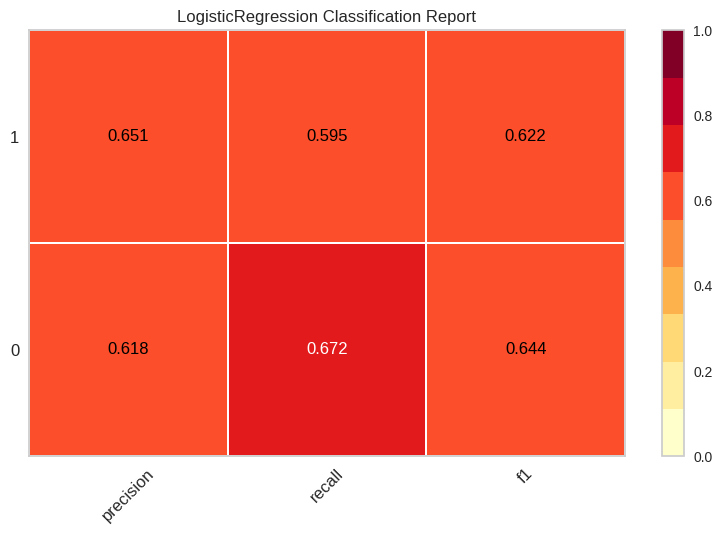

In [24]:
y_pred = classifier.predict(X_test)
print("Accuracy = ",accuracy_score(y_test,y_pred,normalize = True))

print(confusion_matrix(y_test,y_pred))

visualizer = ClassificationReport(classifier, classes=['0','1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()

In [25]:
# KNN model
KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_test)

Accuracy 0.9387414455015857


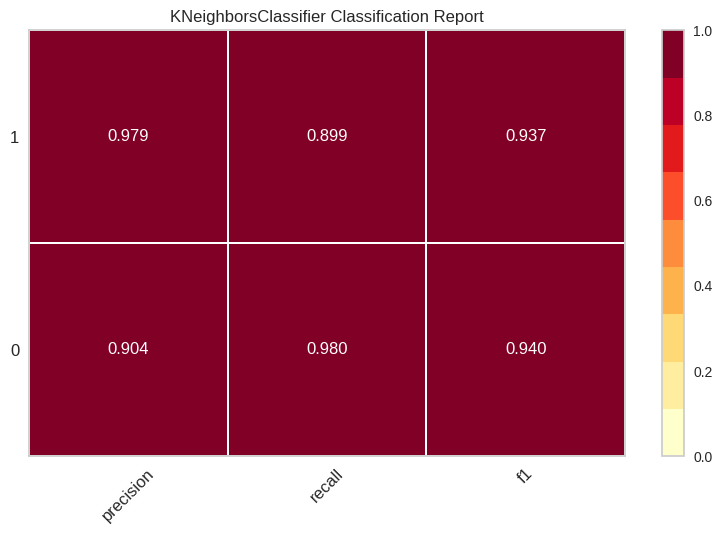

[[2894   59]
 [ 308 2730]]


In [26]:
print("Accuracy",accuracy_score(y_test,y_pred,normalize = True))

visualizer = ClassificationReport(KNN, classes=['0','1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
print(confusion_matrix(y_test,y_pred))

In [27]:
# Decision Tree model
DTC = DecisionTreeClassifier()
DTC.fit(X_train,y_train)
y_pred = DTC.predict(X_test)

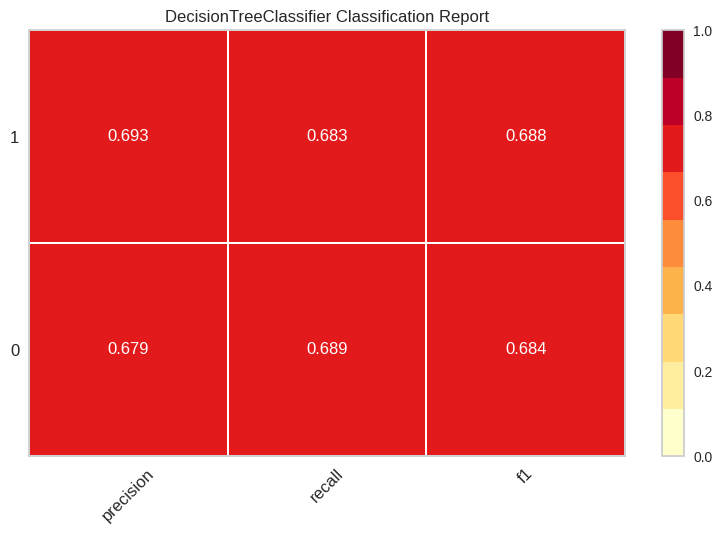

[[2035  918]
 [ 962 2076]]


In [28]:
print("Accuracy",accuracy_score(y_test,y_pred,normalize = True))
visualizer = ClassificationReport(DTC, classes=['0','1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
print(confusion_matrix(y_test,y_pred))

In [42]:
# Stochastic gradient descent model
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier()
SGD.fit(X_train,y_train)
y_pred = SGD.predict(X_test)

Accuracy 0.5900517442830913


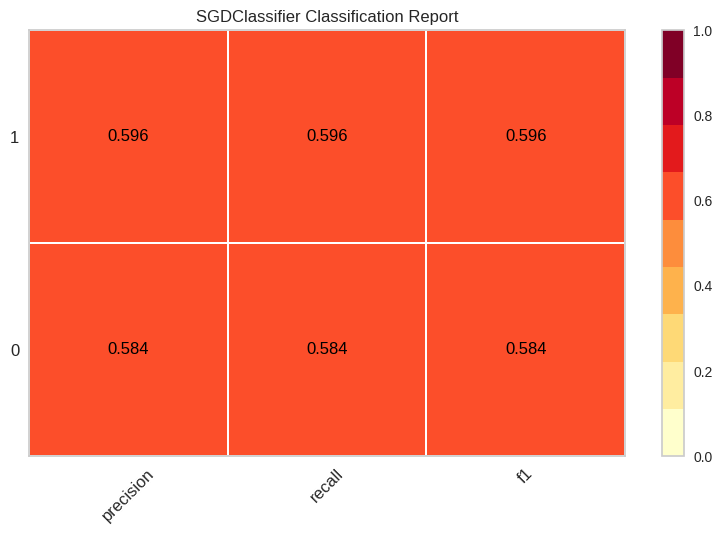

[[1724 1229]
 [1227 1811]]


In [43]:
print("Accuracy",accuracy_score(y_test,y_pred,normalize = True))
visualizer = ClassificationReport(SGD, classes=['0','1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
print(confusion_matrix(y_test,y_pred))

In [31]:
# SVM model
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)

SVC()

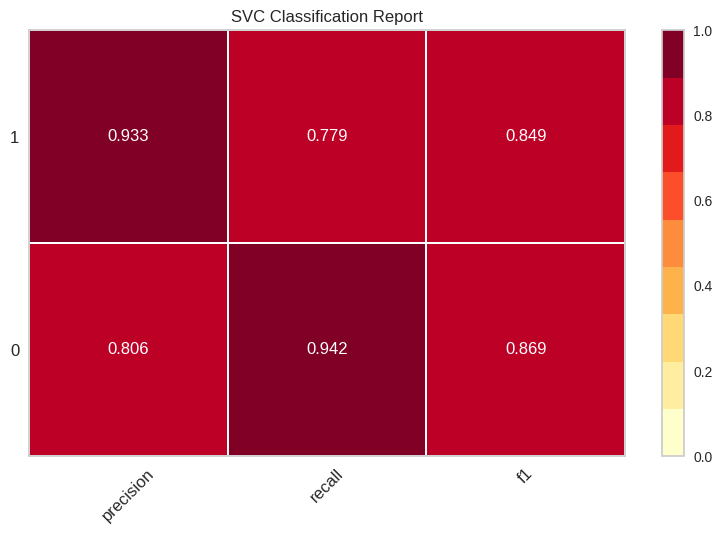

[[1978  975]
 [1502 1536]]


In [32]:
print("Accuracy",accuracy_score(y_test,y_pred,normalize = True))
visualizer = ClassificationReport(svc, classes=['0','1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
print(confusion_matrix(y_test,y_pred))

In [44]:
# Multi layer Perceptron model
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)

MLPClassifier()

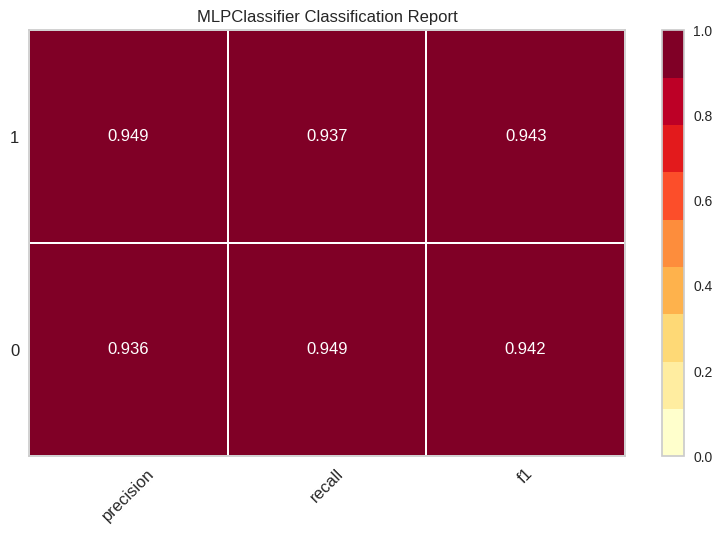

[[2801  152]
 [ 192 2846]]
Accuracy =  0.942580537472876


In [45]:
print("Accuracy = ",accuracy_score(y_test,y_pred,normalize = True))
visualizer = ClassificationReport(mlp, classes=['0','1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
print(confusion_matrix(y_test,y_pred))

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
GPC = GaussianProcessClassifier()
GPC.fit(X_train,y_train)
y_pred = GPC.predict(X_test)

In [ ]:
print("Accuracy",accuracy_score(y_test,y_pred,normalize = True))
visualizer = ClassificationReport(GPC, classes=['0','1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
print(confusion_matrix(y_test,y_pred))